In [1]:
import os
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import glob
from shutil import copyfile

In [3]:
print(len(os.listdir("cell/training/healthy/")))
print(len(os.listdir("cell/training/infected/")))

print(len(os.listdir("cell/validation/healthy/")))
print(len(os.listdir("cell/validation/infected/")))

13623
13636
2599
2612


In [4]:
train = "cell/training/"
validation = "cell/validation/"

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()


Data augmentation , pretrained model

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale= 1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest')


train_ds = train_datagen.flow_from_directory(train,
                                              batch_size = 20,
                                              class_mode = "binary",
                                              target_size = (150,150)) # resize

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) # rescale
validaton_data = validation_datagen.flow_from_directory(validation,
                                                       batch_size = 20,
                                                       class_mode = "binary",
                                                       target_size = (150,150))

Found 27257 images belonging to 2 classes.
Found 5211 images belonging to 2 classes.


In [5]:
train_ds.class_indices

{'healthy': 0, 'infected': 1}

In [6]:
# pretrained model

from keras.applications import VGG16
vgg = VGG16(weights= "imagenet",include_top=False, input_shape = (150,150,3))

In [7]:
from keras.models import Model
from keras import layers, models
  
x = layers.Flatten()(vgg.output)
x = layers.Dense(84, activation = ('relu'))(x)
prediction = layers.Dense(1, activation="sigmoid")(x)

In [8]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [10]:
for layer in vgg.layers:
    layer.trainable = True

In [11]:
from keras.optimizers import Adam

optimizer = keras.optimizers.Adam(lr=0.001,decay = 0.01)
model.compile(loss = "binary_crossentropy",
             optimizer = optimizer,
             metrics = ["accuracy"])

In [12]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="finetuning_tranfer_model.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

In [13]:
history = model.fit_generator(train_ds,epochs = 21, 
                              steps_per_epoch = 27257//20, # images = batch_size * steps
                              validation_data = validaton_data,
                              validation_steps=5211//20,
                             callbacks=callbacks_list)

C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\vaibh\miniconda3\envs\Ai\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/21
1362/1362 [==============================] - 632s 450ms/step - loss: 0.7357 - accuracy: 0.5553 - val_loss: 0.6249 - val_accuracy: 0.6598

Epoch 00001: val_accuracy improved from -inf to 0.65981, saving model to finetuning_tranfer_model.best.hdf5
Epoch 2/21
1362/1362 [==============================] - 623s 458ms/step - loss: 0.5557 - accuracy: 0.7101 - val_loss: 0.1859 - val_accuracy: 0.9471

Epoch 00002: val_accuracy improved from 0.65981 to 0.94712, saving model to finetuning_tranfer_model.best.hdf5
Epoch 3/21
1362/1362 [==============================] - 674s 495ms/step - loss: 0.2264 - accuracy: 0.9265 - val_loss: 0.1555 - val_accuracy: 0.9510

Epoch 00003: val_accuracy improved from 0.94712 to 0.95096, saving model to finetuning_tranfer_model.best.hdf5
Epoch 4/21
1362/1362 [==============================] - 702s 515ms/step - loss: 0.2074 - accuracy: 0.9313 - val_loss: 0.1464 - val_accuracy: 0.9533

Epoch 00004: val_accuracy improved from 0.95096 to 0.95327, saving model t

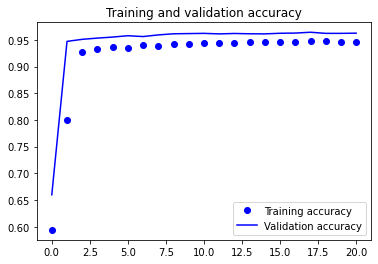

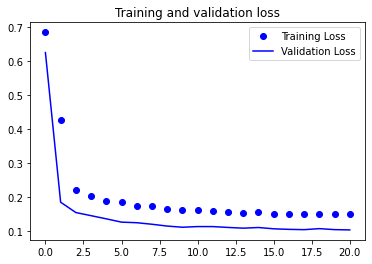

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show() 